In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from anytree import Node, RenderTree
from statsmodels.tsa.stattools import acf
%matplotlib widget

In [2]:
def add_nodes(nodes, parent, child, grandchild, ggchild):
    if parent not in nodes:
        nodes[parent] = Node(parent)  
    if child not in nodes:
        nodes[child] = Node(child)
    if grandchild not in nodes:
        nodes[grandchild] = Node(grandchild)
    if ggchild not in nodes:
        nodes[ggchild] = Node(ggchild)
    nodes[child].parent = nodes[parent]
    nodes[grandchild].parent = nodes[child]
    nodes[ggchild].parent = nodes[grandchild]

In [3]:
df_y_train = pd.read_csv('./y_train.csv')
df_x_train = pd.read_csv('./x_train.csv')

Here we have market data over 20 days. Colums RET_1,...,RET_20 are the residual stock returns in those 20 days. The column DATE is a date index, however, it is randomized and has no continuity

In [4]:
print(df_x_train)

            ID  DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY  \
0            0     0      2        18               5       3            44   
1            1     0      3        43              15       6           104   
2            2     0      4        57              20       8           142   
3            3     0      8         1               1       1             2   
4            4     0     14        36              12       5            92   
...        ...   ...    ...       ...             ...     ...           ...   
418590  418590   223   5703        32              10       4            77   
418591  418591   223   5705        35              12       5            91   
418592  418592   223   5709         2               1       1             5   
418593  418593   223   5710        33              10       4            83   
418594  418594   223   5713        26               7       4            60   

           RET_1  VOLUME_1     RET_2  ...    RET_16

In [17]:
df = df_x_train.fillna(0)#[['DATE','ID','INDUSTRY','INDUSTRY_GROUP',*[col for col in cols if 'RET_' in col]]]

df = df[df['DATE']==0]

df = df[df['SECTOR']==2]
#df = df[df['INDUSTRY_GROUP']==2]
df = df[df['INDUSTRY']==6]
df = df[df['SUB_INDUSTRY']==17]
rets = [col for col in df.columns if 'RET_' in col]
vols = [col for col in df.columns if 'VOLUME_' in col]
nodes = {}  # store references to created nodes 
# data.apply(lambda x: add_nodes(nodes, x["Parent"], x["Child"]), axis=1)  # 1-liner
for parent, child, grandchild, ggchild in zip(df["SECTOR"],(df["INDUSTRY_GROUP"]),(df["INDUSTRY"]),df["SUB_INDUSTRY"]):
    #print(parent, child)
    add_nodes(nodes, parent, 'Industry group '+str(child),'Industry '+str(grandchild), 'Sub industry '+str(ggchild))

#roots = list(df[~df["INDUSTRY"].isin(df["INDUSTRY_GROUP"])]["INDUSTRY"].unique())
roots = np.unique(df[['SECTOR']].T.values[0,:])
for root in roots:         # you can skip this for roots[0], if there is no forest and just 1 tree
    for pre, _, node in RenderTree(nodes[root]):
        print("%s%s" % (pre, node.name))
print(roots)

2
└── Industry group 2
    └── Industry 6
        └── Sub industry 17
[2]


In [18]:
norm_rets = []
norm_vols = []
corr = []
for jj in range(df.values.shape[0]):
    norm_rets+=[(df[rets].iloc[jj]-np.mean(df[rets].iloc[jj]))/np.std(df[rets].iloc[jj])]
    norm_vols+=[((df[vols].iloc[jj]-np.mean(df[vols].iloc[jj]))/np.std(df[vols].iloc[jj])).fillna(0).values]
    corr += [np.correlate(norm_rets[jj],norm_vols[jj])[0]]
norm_vols=np.array(norm_vols)    
#norm_rets = np.array(norm_rets[0])
#norm_vols = np.array(norm_vols[0])


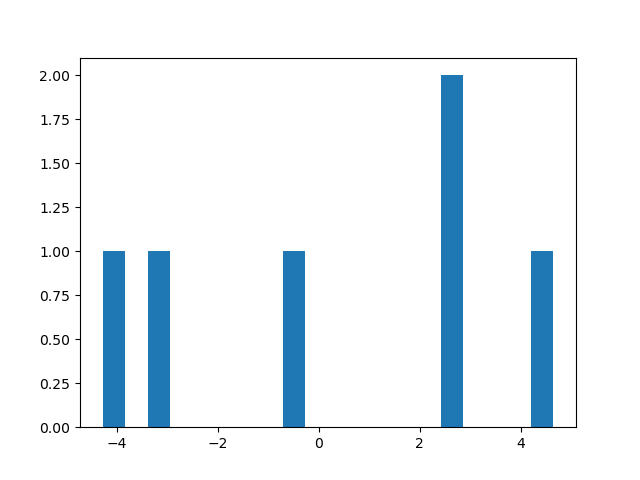

In [19]:
fig, ax = plt.subplots()
bins=ax.hist(corr,bins=20)
#bins=ax.hist(np.mean(norm_rets,axis=1),bins=300)
#bins=ax.hist(np.mean(norm_vols,axis=1),bins=300)

In [20]:
corr = []
for jj in range(df.values.shape[0]):
    for ii in range(jj+1,df.values.shape[0]):
        corr += [np.correlate(norm_rets[jj],norm_rets[ii])[0]]
norm_vols=np.array(norm_vols)  

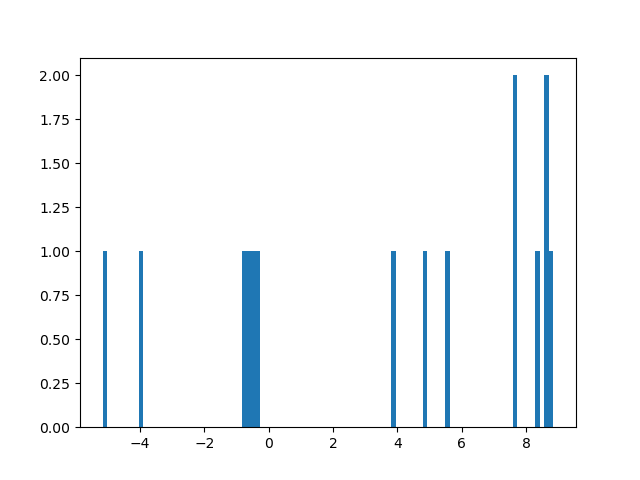

In [21]:
fig, ax = plt.subplots()
bins=ax.hist(corr,bins=100)

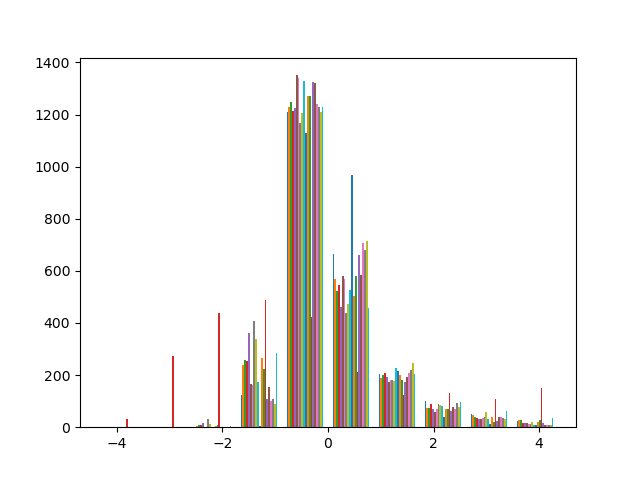

In [322]:
plt.close('all')
fig, ax = plt.subplots()
bins = ax.hist(norm_vols)

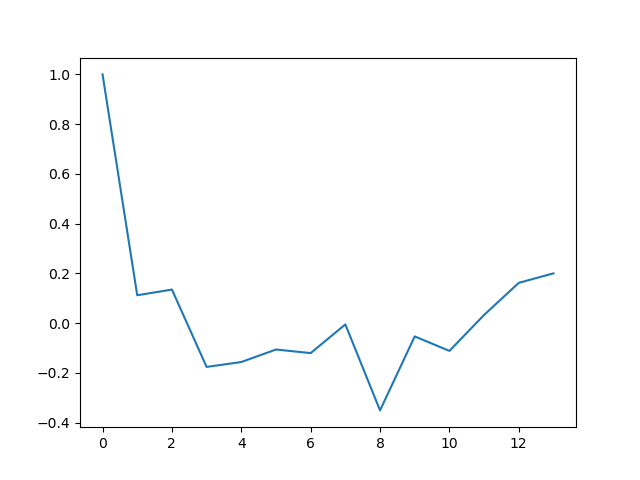

In [335]:
fig, ax = plt.subplots()

ax.plot(acf(norm_vols[10,:]))
#norm_vols
pairs = np.reshape(norm_vols[0,:],(10,2))
#ax.plot(pairs[:,0],pairs[:,1],'.')

In [37]:
rets = [col for col in df.columns if 'RET_' in col]
vols = [col for col in df.columns if 'VOLUME_' in col]
#df_x_train[df_x_train['DATE']==0].groupby('INDUSTRY')[[*rets]].shift(1)

(90, 20)
9.072136453945186


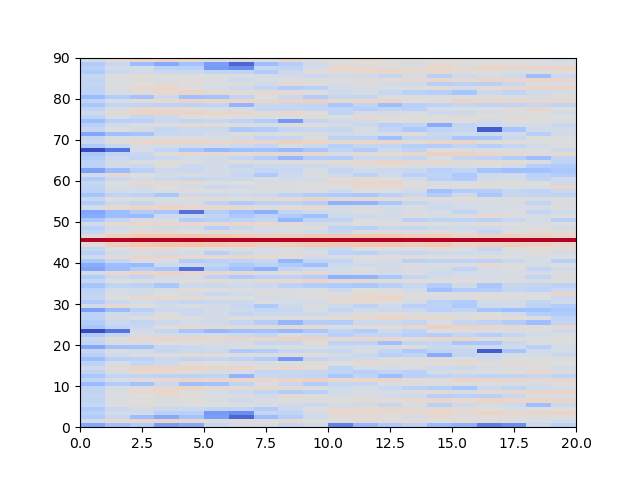

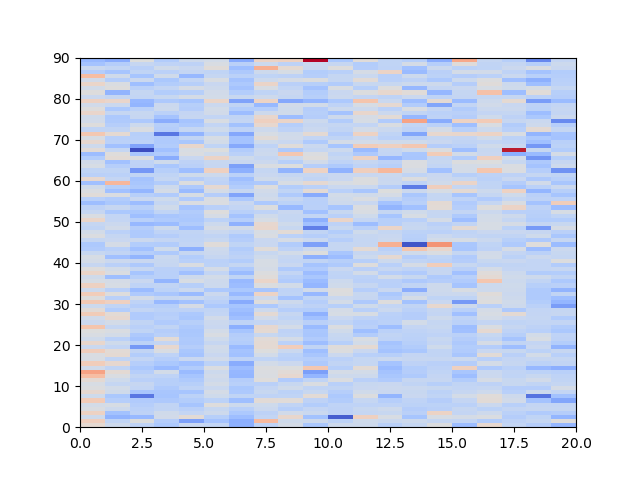

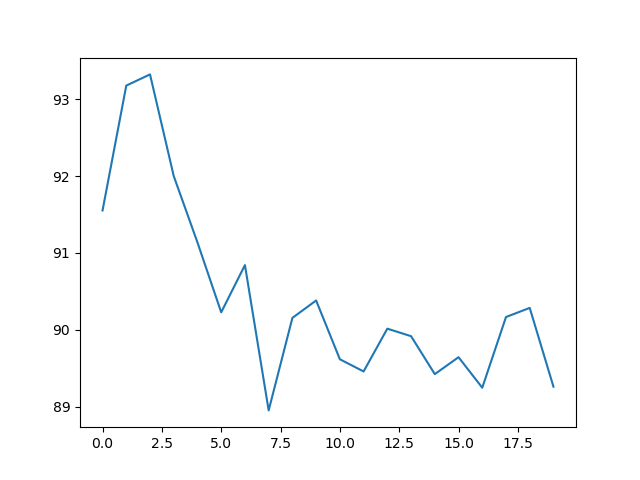

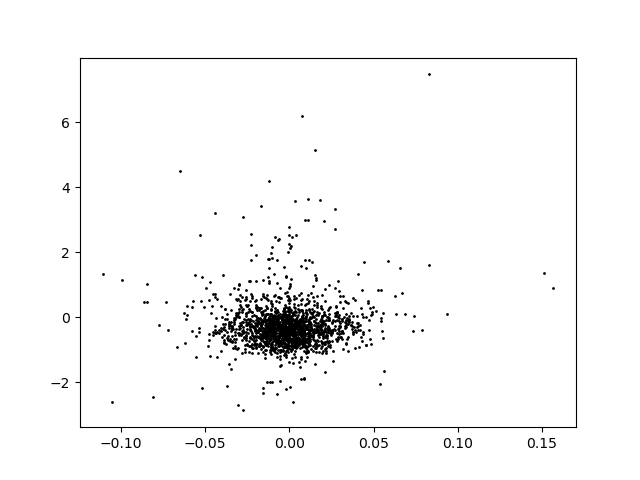

In [24]:
df_day_0 = df_x_train[df_x_train['DATE'] == 0].dropna()
df_day_0 = df_day_0[df_day_0['SECTOR'] == 1]
rets = [col for col in df_day_0.columns if 'RET_' in col]
vols = [col for col in df_day_0.columns if 'VOLUME_' in col]
rets = df_day_0[rets].to_numpy()
vols = df_day_0[vols].to_numpy()
p0 = 1
prices = np.zeros_like(rets) 
prices[:,0] = p0*(rets[:,0]+1)
for jj in range(rets[0,:].size-1):
    prices[:,jj+1] = prices[:,jj]*(rets[:,jj]+1)
print(rets.shape)
plt.close('all')
fig, ax = plt.subplots()
ax.pcolormesh(np.fft.fftshift(np.log(abs(np.fft.fft(prices,axis=0))**2),axes=0),rasterized=True,vmax=8,cmap='coolwarm')
print(np.fft.fftshift(np.log(abs(np.fft.fft(prices,axis=0))**2),axes=0).max())
fig, ax = plt.subplots()
ax.pcolormesh((rets),rasterized=True,cmap='coolwarm')
fig, ax = plt.subplots()
ax.plot(np.sum(prices,axis=0))

fig,ax = plt.subplots()
for jj in range(prices[:,0].size):
    ax.scatter(rets[jj,:],vols[jj,:],c='k',s=1.0)

In [215]:
cols = df_x_train.columns
df = df_x_train#[['DATE','ID','INDUSTRY','INDUSTRY_GROUP',*[col for col in cols if 'RET_' in col]]]

df = df[df['DATE']==0]

df = df[df['SECTOR']==0]
print(df)
#df = df[df['INDUSTRY_GROUP']==5]
#df = df[df['SUB_INDUSTRY']==142]
prices = df[[*[col for col in cols if 'RET_'in col]]]
prices = prices.to_numpy()
vols = df[[*[col for col in cols if 'VOLUME_'in col]]]
vols = vols.to_numpy()
print(vols)
corr = [] 
corr_price_volume =[]
for ii in range(prices.shape[0]):
    corr_price_volume+=[np.correlate(prices[ii,:],vols[ii,:])]
    for jj in range(ii+1, prices.shape[0],1):
        corr += [np.correlate(prices[ii,:],prices[jj,:])]
#print(prices)
#print(prices.corr(numeric_only=True))
#[print(col) for col in cols if 'RET_' in col]


        ID  DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY  \
74      74     0    736         0               0       0             0   
217    217     0   2208         0               0       0             0   
239    239     0   2279         0               0       0             0   
302    302     0   2448         0               0       0             0   
306    306     0   2454         0               0       0             0   
321    321     0   2484         0               0       0             0   
342    342     0   2523         0               0       0             0   
492    492     0   2939         0               0       0             0   
579    579     0   3035         0               0       0             0   
595    595     0   3056         0               0       0             0   
596    596     0   3058         0               0       0             0   
612    612     0   3074         0               0       0             0   
643    643     0   3113  

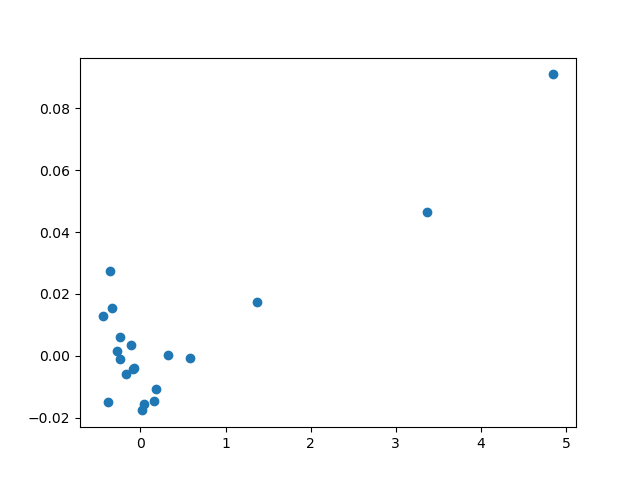

In [129]:
plt.close('all')
fig, ax = plt.subplots()
#ax.plot((corr),'.')
#ax.plot((corr_price_volume),'.')
#ax.plot(vols[1,:])
ax.scatter(vols[1,:],prices[1,:])

In [89]:
np.unique(df[['SECTOR']].T.values[0,:])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

AttributeError: 'DataFrame' object has no attribute 'data'

In [92]:
print(df_x_train)
print(df_x_train['STOCK'][:2377])
print(df_x_train['DATE'][2377:2*2377+445])

            ID  DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY  \
0            0     0      2        18               5       3            44   
1            1     0      3        43              15       6           104   
2            2     0      4        57              20       8           142   
3            3     0      8         1               1       1             2   
4            4     0     14        36              12       5            92   
...        ...   ...    ...       ...             ...     ...           ...   
418590  418590   223   5703        32              10       4            77   
418591  418591   223   5705        35              12       5            91   
418592  418592   223   5709         2               1       1             5   
418593  418593   223   5710        33              10       4            83   
418594  418594   223   5713        26               7       4            60   

           RET_1  VOLUME_1     RET_2  ...    RET_16

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00,
        1.00000e+00, 4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00,
        2.00000e+00, 2.00000e+00, 4.00000e+00, 2.00000e+00, 8.00000e+00,
        6.00000e+00, 6.00000e+00, 6.00000e+00, 2.00000e+00, 4.00000e+00,
        4.00000e+00, 4.00000e+00, 7.00000e+00, 1.30000e+01, 1.60000e+01,
        2.30000e+01, 1.40000e+01, 1.90000e+01, 2.20000e+01, 2.60000e+01,
        3.50000e+01, 4.70000e+01, 6.80000e+01, 8.80000e+01, 1.13000e+02,
        1.60000e+02, 1.86000e+02, 2.80000e+02, 3.84000e+02, 5.65000e+02,
        9.15000e+02, 1.36400e+03, 2.33600e+03, 3.84

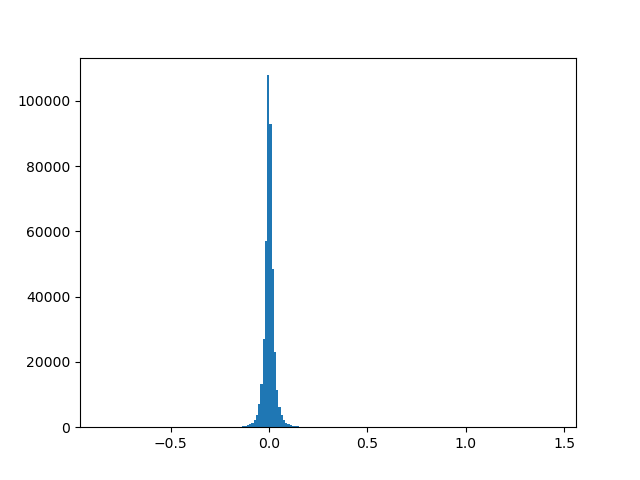

In [40]:
fig, ax = plt.subplots()
ax.hist(df_x_train['RET_1'],bins=200)

In [21]:
#df_x_train["RET_1"].shape

(418595,)

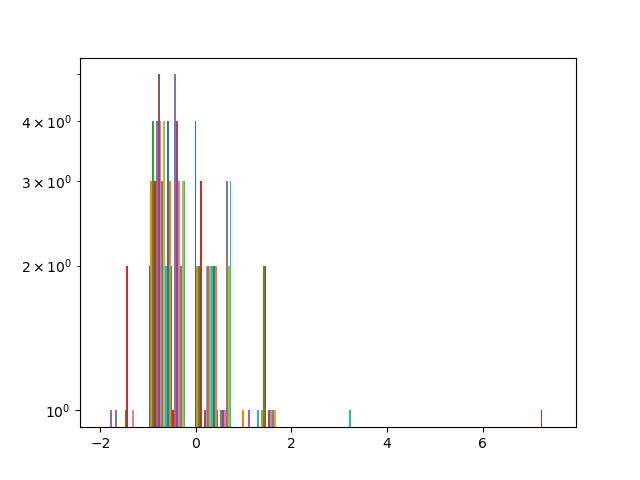

In [295]:
plt.close('all')
fig,ax = plt.subplots()
bins = ax.hist((df[vols]))
#bins = ax.hist(df_x_train[rets],bins=5000)
ax.set_yscale('log')

In [32]:
abs(np.fft.rfft(df[rets].iloc[0]))**2

array([0.10651079, 0.115756  , 0.08183348, 0.12355218, 0.0338339 ,
       0.04741375, 0.11660544, 0.02887377, 0.00658303, 0.01092657,
       0.0040004 ])

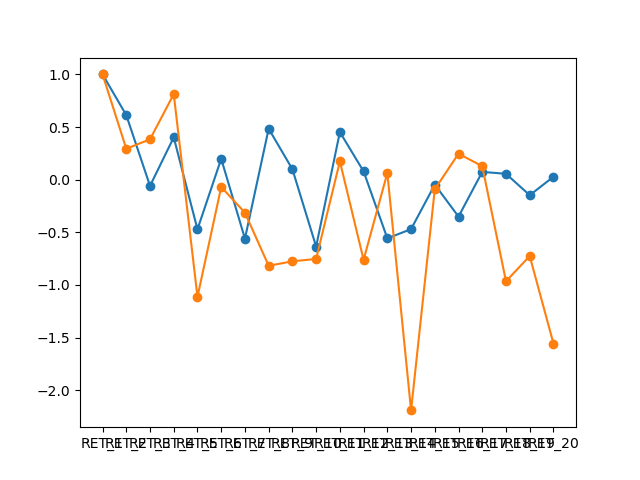

In [244]:
stock_idx = 6
fig, ax = plt.subplots()
ax.plot(rets,df[rets].iloc[stock_idx]/np.max(df[rets].iloc[stock_idx]),'-o')
ax.plot(rets,df[vols].iloc[stock_idx]/np.max(df[vols].iloc[stock_idx]),'-o')

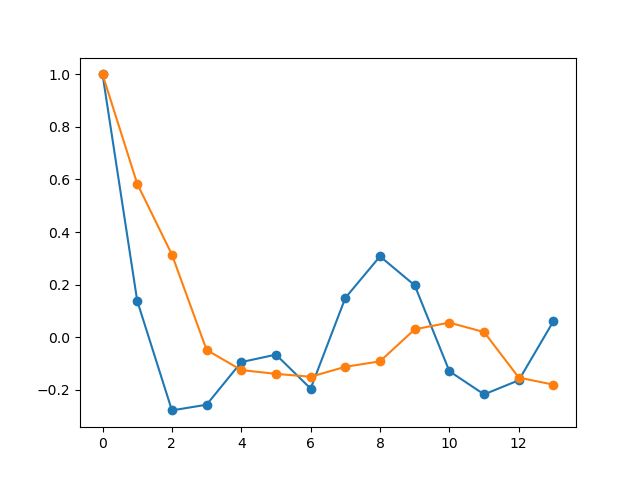

In [245]:
stick_idx = 2
plt.close('all')
fig, ax = plt.subplots()
ax.plot(acf(df[rets].iloc[stick_idx]),'-o')
#ax.hlines(np.std(df[rets].iloc[stick_idx])/np.sqrt(20),0,20)
#ax.hlines(-np.std(df[rets].iloc[stick_idx])/np.sqrt(20),0,20)
ax.plot(acf(df[vols].iloc[stick_idx]),'-o')
#ax.hlines(np.std(df[vols].iloc[0])/np.sqrt(20),0,20)
#ax.hlines(-np.std(df[vols].iloc[0])/np.sqrt(20),0,20)


In [246]:
np.std(df[rets].iloc[0])

0.020303351781379802

In [247]:
pairs = np.reshape(df[rets].iloc[3],(10,2))

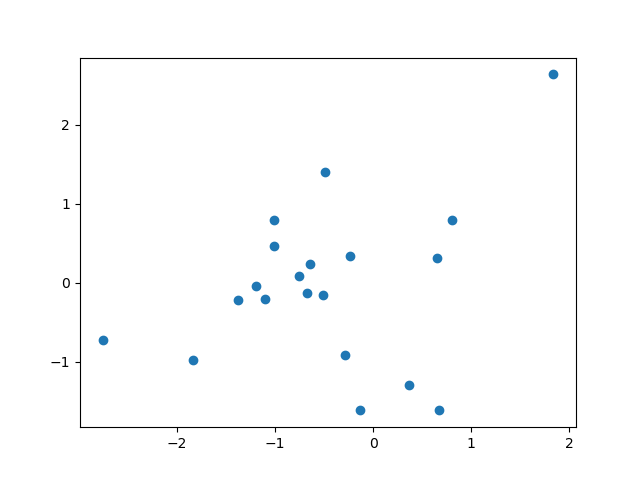

In [248]:
fig, ax = plt.subplots()
ax.scatter(df[vols].iloc[3]/np.std((df[vols].iloc[3])),df[rets].iloc[3]/np.std((df[rets].iloc[3])))

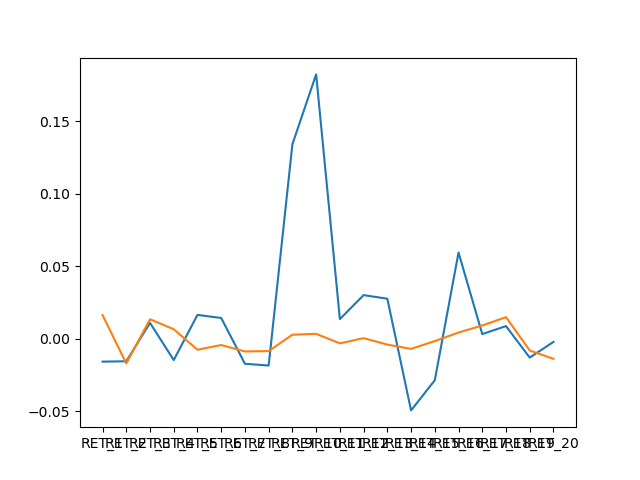

In [159]:
plt.close('all')
lenght = 20
fs = 1/lenght
t = np.arange(0,lenght)
freq = np.fft.fftfreq(lenght,1)#1/t
spectrum = np.fft.fft(df[rets].iloc[0])/lenght
fit = spectrum*np.exp(-1j*2*np.pi*freq*t)#spectrum[0]*np.ones(lenght)+spectrum[1]*np.exp(1j*freq[1]*2*np.pi*t)+spectrum[2]*np.exp(1j*freq[2]*2*np.pi*t)+spectrum[3]*np.exp(1j*freq[3]*2*np.pi*t)

fig, ax = plt.subplots()
ax.plot(df[rets].iloc[0])
ax.plot(np.real(fit))

In [160]:
freq

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
       -0.1 , -0.05])

In [168]:
(np.linspace(t[0]/freq.size/2,t[-1]/freq.size/2,freq.size))

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475])

In [156]:
fit

array([ 0.016318  +0.00000000e+00j, -0.01615886+5.31801428e-03j,
        0.00806709-1.18112549e-02j,  0.01705074+4.26061588e-03j,
        0.00270572+8.78998371e-03j, -0.00999815+4.30944640e-03j,
       -0.01126587+1.28294133e-02j,  0.00489328+6.94552283e-03j,
       -0.00055491-4.01866345e-03j, -0.00204338-4.81051263e-03j,
        0.00316244-1.58423351e-17j,  0.00117442+5.09285450e-03j,
        0.00281105-2.92499632e-03j,  0.00804122-2.74285095e-03j,
        0.01665522+3.75730324e-03j,  0.00999815+4.30944640e-03j,
        0.00297765+8.70162900e-03j,  0.01629866+6.57526044e-03j,
        0.00041607-1.42972228e-02j, -0.01619864+5.19557511e-03j])